In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

In [4]:
f = np.load('/home/user/github/portfolio-manager/BackTest/inputs.npz')

In [5]:
f.files

['arr_0', 'arr_1']

In [6]:
Xs, ys = f['arr_0'], f['arr_1']

(array([1.170000e+02, 2.672400e+04, 1.045875e+06, 3.941000e+03,
        1.340000e+02, 2.700000e+01, 7.000000e+00, 1.000000e+00,
        1.000000e+00, 1.000000e+00]),
 array([-0.8580644 , -0.48589471, -0.11372503,  0.25844465,  0.63061433,
         1.00278402,  1.3749537 ,  1.74712338,  2.11929307,  2.49146275,
         2.86363243]),
 <BarContainer object of 10 artists>)

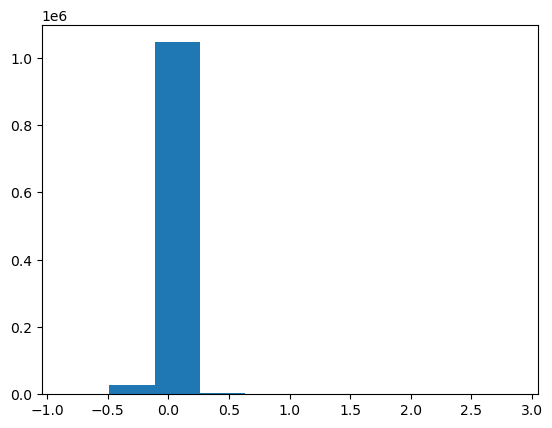

In [7]:
plt.hist(ys)

In [8]:
Xs[:, 0, 1].reshape(-1, 1, 1)

array([[[16.30069273]],

       [[16.54861691]],

       [[16.48663075]],

       ...,

       [[ 2.94881126]],

       [[ 2.96140718]],

       [[ 2.99461735]]])

In [9]:
scales = Xs[:, 0, 1].reshape(-1, 1, 1).copy()
Xs[:, :, [5]] /= scales
Xs[:, :, :4] /= scales

In [ ]:
for i in range(4):
    plt.plot(Xs[399950, :, i])
plt.plot(Xs[399950, :, 5])    

In [10]:
def bresenham(img, x0, y0, x1, y1):
    dx = abs(x1 - x0)
    sx = 1 if x0 < x1 else -1 
    dy = -abs(y1 - y0)
    sy = 1 if y0 < y1 else -1
    error = dx + dy

    while True:
        img[x0, y0] = 255
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * error
        if e2 >= dy:
            if x0 == x1:
                break 
            error += dy
            x0 += sx
        if e2 <= dx:
            if y0 == y1:
                break
            error += dx
            y0 += sy

def make_image(sample, ema=True, volume=True):
    height_bars = 96
    width = sample.shape[0] * 3
    img_ohlc = np.zeros((width, height_bars), dtype=np.uint8)

    max_price = max(sample[:, :4].max(), sample[:, 5].max())
    min_price = min(sample[:, :4].min(), sample[:, 5].min())
    height_scaler = (height_bars - 1) / (max_price - min_price)

    ema_y_prev = None

    for t in range(sample.shape[0]):
        open_y = round((sample[t, 1] - min_price) * height_scaler)
        img_ohlc[3*t, open_y] = 255
        close_y = round((sample[t, 0] - min_price) * height_scaler)
        img_ohlc[3*t+2, close_y] = 255

        low_y = round((sample[t, 3] - min_price) * height_scaler)
        high_y = round((sample[t, 2] - min_price) * height_scaler)
        img_ohlc[3*t+1, low_y:high_y] = 255

        if ema:
            ema_y = round((sample[t, 5] - min_price) * height_scaler)
            img_ohlc[3*t+1, ema_y] = 255
            if ema_y_prev is not None:
                bresenham(img_ohlc, 3*t-2, ema_y_prev, 3*t+1, ema_y)
            ema_y_prev = ema_y

    if not volume:
        return img_ohlc.T
    
    height_vol = 24
    height_whole = height_bars + height_vol if volume else 0
    img_whole = np.zeros((width, height_whole), dtype=np.uint8)
    img_whole[:, :height_bars] = img_ohlc

    max_vol = sample[:, 4].max()
    vol_scaler = (height_vol - 1)/max_vol 
    for t in range(sample.shape[0]):
        vol_y = round(sample[t, 4] * vol_scaler)
        img_whole[3*t+1, height_whole-vol_y-1:height_whole-1] = 255

    return img_whole.T



In [11]:
class StockCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=(5, 3), padding=1),
            torch.nn.LeakyReLU(negative_slope=0.01, inplace=True),
            torch.nn.MaxPool2d((2, 1))
        )
        self.block2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=(5, 3), padding=1),
            torch.nn.LeakyReLU(negative_slope=0.01, inplace=True),
            torch.nn.MaxPool2d((2, 1))
        )
        self.out_block = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(161280, 2),
            torch.nn.Softmax(dim=-1))

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.out_block(x)
        return x

In [12]:
ys_pt = torch.LongTensor(ys > 0)
xs_pt = torch.zeros(size=(Xs.shape[0], 120, 45), dtype=torch.uint8)

In [13]:
for i in range(Xs.shape[0]):
    xs_pt[i] = torch.tensor(make_image(Xs[i]))

In [14]:
torch.cuda.is_available()

True

In [15]:
split_idx = round(ys_pt.shape[0] * 0.85)
ys_train, ys_valid = ys_pt[:split_idx], ys_pt[split_idx:]
xs_train, xs_valid = xs_pt[:split_idx], xs_pt[split_idx:]

In [16]:
ds_train = torch.utils.data.TensorDataset(xs_train, ys_train)
ds_valid = torch.utils.data.TensorDataset(xs_valid, ys_valid)

BATCH_SIZE = 128
EPOCHS = 100
LEARNING_RATE = 1e-4
DEVICE = 'cuda:0'

m = StockCNN()
m = m.to(DEVICE)
m = torch.nn.DataParallel(m)
opt = torch.optim.Adam(m.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

# ds_train_bs = torch.utils.data.TensorDataset(xs_train[:BATCH_SIZE], ys_train[:BATCH_SIZE])

dl_train = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=BATCH_SIZE, shuffle=True)

for ep in range(EPOCHS):
    train_total_loss = 0
    train_n_batches = 0
    train_n_hits = 0
    train_n_total = 0

    for xs, ys in dl_train:
        xs = xs.to(DEVICE)
        xs = xs.unsqueeze(1).float() / 255.0
        ys = ys.to(DEVICE).squeeze()
        opt.zero_grad()
        y_hat = m(xs)
        loss = loss_fn(y_hat, ys)
        loss.backward()

        train_total_loss += loss.cpu().item()
        train_n_batches += 1
        train_n_hits += (torch.argmax(y_hat, dim=-1) == ys).sum().cpu().item()
        train_n_total += y_hat.shape[0]


        # print(f'Loss={loss.cpu().item()}, {(torch.argmax(y_hat, dim=-1) == ys).sum().cpu().item()/y_hat.shape[0]}')
        opt.step()

    valid_total_loss = 0
    valid_n_batches = 0
    valid_n_hits = 0
    valid_n_total = 0

    with torch.inference_mode():
        for xs, ys in dl_valid:
            xs = xs.to(DEVICE)
            xs = xs.unsqueeze(1).float() / 255.0
            ys = ys.to(DEVICE).squeeze()
            y_hat = m(xs)
            loss = loss_fn(y_hat, ys)
            
            valid_total_loss += loss.cpu().item()
            valid_n_batches += 1
            valid_n_hits += (torch.argmax(y_hat, dim=-1) == ys).sum().cpu().item()
            valid_n_total += y_hat.shape[0]     

    print(f'Epoch {ep+1}: Train({train_total_loss/train_n_batches}, {100.0 * train_n_hits/train_n_total:.2f}), Valid({valid_total_loss/valid_n_batches}, {100.0 * valid_n_hits/valid_n_total:.2f})')       


Epoch 1: Train(0.691105673861927, 52.80), Valid(0.6896978617186781, 53.60)
Epoch 2: Train(0.6897121509077365, 53.39), Valid(0.689527026163606, 53.70)
Epoch 3: Train(0.6879038630357374, 54.12), Valid(0.6904789789826292, 52.91)


KeyboardInterrupt: 

: 

In [ ]:
print('Test')

In [ ]:
plt.imshow(xs[0, 0].cpu().numpy())

In [ ]:
ys

In [ ]:
y_hat.shape

In [ ]:
ys.shape

In [ ]:
loss_fn(y_hat, ys.squeeze())

In [ ]:
batch_pt = torch.stack([torch.FloatTensor(x)/255.0 for x in batch])
batch_pt = batch_pt.unsqueeze(dim=1)

In [ ]:
batch_pt.shape

In [ ]:

r = m(batch_pt)

In [ ]:
r.shape

In [ ]:
128 * 28 * 45

In [ ]:
batch_pt.shape

In [ ]:
(1.0579706111328149 - 0.9999994104739358) * 1655.9946819955387

In [ ]:
max_price = max(x[:, :4].max(), x[:, 5].max())
min_price = min(x[:, :4].min(), x[:, 5].min())

In [ ]:
max_price

In [ ]:
min_price

In [ ]:
x

In [ ]:
plt.imshow(make_image(x))

In [ ]:
plt.imshow(make_image(Xs[1843]))

In [ ]:
plt.imshow(make_image(Xs[18343]))

In [ ]:
price_series = np.cumprod(Xs2 + 1, axis=-1)

In [ ]:
Xs[:10]